In [1]:
from pymongo import MongoClient
from pprint import pprint
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import itertools
import time
import re

In [2]:
%%time

ascension_level = 15
floor_reached = 40

client = MongoClient('mongodb://localhost:27017')
db = client.spire
status = db.command('serverStatus')
runs = db.runs

not_picks_agg = [
    {
        '$match': {
            'event.character_chosen': 'IRONCLAD', 
            'event.floor_reached': {
                '$gte': floor_reached
            }, 
            'event.ascension_level': {
                '$gte': ascension_level
            }
        }
    }, {
        '$project': {
            'event.card_choices': 1, 
            'event.ascension_level': 1
        }
    }, {
        '$unwind': {
            'path': '$event.card_choices'
        }
    }, {
        '$unwind': {
            'path': '$event.card_choices.not_picked'
        }
    }, {
        '$project': {
            'event.card_choices.not_picked': 1, 
            'event.card_choices.floor': 1, 
            'event.ascension_level': 1
        }
    }, {
        '$group': {
            '_id': {
                'not_picked': '$event.card_choices.not_picked', 
                'floor': '$event.card_choices.floor'
            }, 
            'count': {
                '$sum': 1
            }, 
            'card': {
                '$first': '$event.card_choices.not_picked'
            }, 
            'floor': {
                '$first': '$event.card_choices.floor'
            }
        }
    }, {
        '$sort': {
            'count': -1
        }
    }
]
not_picks_result = runs.aggregate(not_picks_agg)
tmp = pd.DataFrame(list(not_picks_result))
tmp

CPU times: user 132 ms, sys: 509 µs, total: 132 ms
Wall time: 2.67 s


,_id,count,card,floor
0,"{'not_picked': 'Brutality', 'floor': 16}",1719,Brutality,16.0
1,"{'not_picked': 'Exhume', 'floor': 16.0}",1683,Exhume,16.0
2,"{'not_picked': 'Bludgeon', 'floor': 16.0}",1632,Bludgeon,16.0
3,"{'not_picked': 'Berserk', 'floor': 16}",1610,Berserk,16.0
4,"{'not_picked': 'Juggernaut', 'floor': 16}",1576,Juggernaut,16.0
...,...,...,...,...
10105,"{'not_picked': 'Ball Lightning+1', 'floor': 39.0}",1,Ball Lightning+1,39.0
10106,"{'not_picked': 'Cold Snap+1', 'floor': 37}",1,Cold Snap+1,37.0
10107,"{'not_picked': 'PiercingWail', 'floor': 20.0}",1,PiercingWail,20.0
10108,"{'not_picked': 'Flex', 'floor': 69.0}",1,Flex,69.0


In [3]:
commons = [
    'Wild Strike',
    'Perfected Strike',
    'Anger',
    'Iron Wave',
    'Heavy Blade',
    'Clothesline',
    'Flex',
    'Havoc',
    'Pommel Strike',
    'Warcry',
    'Twin Strike',
    'True Grit',
    'Thunderclap',
    'Sword Boomerang',
    'Body Slam',
    'Clash',
    'Armaments',
    'Cleave',
    'Shrug It Off',
    'Headbutt',
]
uncommons = [
    'Shockwave',
    'Intimidate',
    'Bloodletting',
    'Burning Pact',
    'Spot Weakness',
    'Metallicize',
    'Rampage',
    'Inflame',
    'Seeing Red',
    'Second Wind',
    'Searing Blow',
    'Rupture',
    'Reckless Charge',
    'Sever Soul',
    'Rage',
    'Disarm',
    'Pummel',
    'Power Through',
    # missing items
    'Entrench',
    # missing items
]
rares = [
    'Demon Form',
    'Juggernaut',
    'Offering',
    'Feed',
    'Corruption',
    'Berserk',
    'Reaper',
    'Bludgeon',
    'Limit Break',
    'Double Tap',
    'Exhume',
    'Immolate',
    'Fiend Fire',
    'Barricade',
    'Brutality',
    'Impervious',
]

In [4]:
not_picks_df = tmp.pivot(index='card', columns='floor')['count']
not_picks_df.loc['Bludgeon'][:30]

floor
0.0       46.0
1.0        NaN
2.0        3.0
3.0        5.0
4.0        9.0
5.0       15.0
6.0       48.0
7.0       55.0
8.0       40.0
9.0        NaN
10.0      52.0
11.0      32.0
12.0      51.0
13.0      44.0
14.0      59.0
15.0       1.0
16.0    1632.0
17.0       NaN
18.0       2.0
19.0       5.0
20.0       9.0
21.0      12.0
22.0      25.0
23.0      55.0
24.0      52.0
25.0      45.0
26.0       NaN
27.0      54.0
28.0      52.0
29.0      50.0
30.0      62.0
Name: Bludgeon, dtype: float64

In [5]:
%%time
picks_agg = [
    {
        '$match': {
            'event.character_chosen': 'IRONCLAD', 
            'event.floor_reached': {
                '$gte': floor_reached
            }, 
            'event.ascension_level': {
                '$gte': ascension_level
            }
        }
    }, {
        '$project': {
            'event.card_choices': 1, 
            'event.ascension_level': 1
        }
    }, {
        '$unwind': {
            'path': '$event.card_choices'
        }
    # }, {
    #     '$match': {
    #         'event.card_choices.picked': {
    #             '$ne': 'SKIP'
    #         }
    #     }
    }, {
        '$group': {
            '_id': {
                'picked': '$event.card_choices.picked', 
                'floor': '$event.card_choices.floor'
            }, 
            'count': {
                '$sum': 1
            }, 
            'card': {
                '$first': '$event.card_choices.picked'
            }, 
            'floor': {
                '$first': '$event.card_choices.floor'
            }
        }
    }, {
        '$sort': {
            'count': -1
        }
    }
]
picks_result = runs.aggregate(picks_agg)
tmp = pd.DataFrame(list(picks_result))
tmp

CPU times: user 39.7 ms, sys: 0 ns, total: 39.7 ms
Wall time: 805 ms


,_id,count,card,floor
0,"{'picked': 'SKIP', 'floor': 35}",5877,SKIP,35.0
1,"{'picked': 'SKIP', 'floor': 18.0}",4543,SKIP,18.0
2,"{'picked': 'SKIP', 'floor': 31}",3490,SKIP,31.0
3,"{'picked': 'SKIP', 'floor': 48}",3007,SKIP,48.0
4,"{'picked': 'SKIP', 'floor': 39}",2935,SKIP,39.0
...,...,...,...,...
7508,"{'picked': 'Flying Knee', 'floor': 13}",1,Flying Knee,13.0
7509,"{'picked': 'Chrysalis+1', 'floor': 46.0}",1,Chrysalis+1,46.0
7510,"{'picked': 'Double Tap+1', 'floor': 46}",1,Double Tap+1,46.0
7511,"{'picked': 'ThirdEye+1', 'floor': 28}",1,ThirdEye+1,28.0


In [6]:
picks_df = tmp.pivot(index='card', columns='floor')['count']
picks_df.loc['Bludgeon'][16]

208.0

In [7]:
not_picks_df.loc['Bludgeon+1'][16]

107.0

In [8]:
not_picks_df.loc['Bludgeon'][16]

1632.0

In [9]:
offered_df = picks_df + not_picks_df

In [10]:
offered_df.loc['Bludgeon'][16]

1840.0

In [11]:
pickrate_df = picks_df / offered_df
print('offered')
print(offered_df.loc[['Bludgeon', 'Limit Break', 'Offering']].iloc[: , 16:30])
print('pickrate')
print(pickrate_df.loc[['Bludgeon', 'Limit Break', 'Offering']].iloc[: , 16:30])


offered
floor          16.0  17.0  18.0  19.0  20.0  21.0  22.0  23.0  24.0  25.0  \
card                                                                        
Bludgeon     1840.0   NaN   NaN   6.0  12.0  18.0  30.0  70.0  68.0  57.0   
Limit Break  2000.0   NaN   NaN  11.0  21.0  20.0  27.0  71.0  72.0  76.0   
Offering     2160.0   NaN   NaN  12.0  19.0  18.0  36.0  95.0  95.0  64.0   

floor        26.0  27.0  28.0  29.0  
card                                 
Bludgeon      NaN  68.0  63.0  62.0  
Limit Break   NaN  75.0  54.0  68.0  
Offering      NaN  68.0  50.0  75.0  
pickrate
floor            16.0  17.0  18.0      19.0      20.0      21.0      22.0  \
card                                                                        
Bludgeon     0.113043   NaN   NaN  0.166667  0.250000  0.333333  0.166667   
Limit Break  0.483500   NaN   NaN  0.545455  0.571429  0.700000  0.518519   
Offering     0.538889   NaN   NaN  0.750000  0.789474  0.777778  0.861111   

floor            23.0

AxesSubplot(0.125,0.125;0.775x0.755)


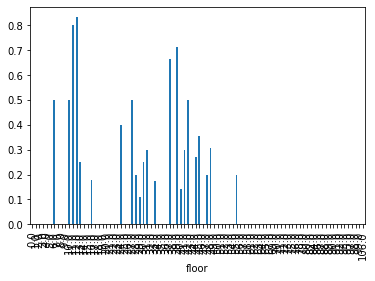

In [12]:
import matplotlib.pyplot as plt
print(pickrate_df.loc['Bludgeon+1'].T.plot(kind="bar"))

[<AxesSubplot:title={'center':'Wild Strike'}, xlabel='floor'>
 <AxesSubplot:title={'center':'Perfected Strike'}, xlabel='floor'>
 <AxesSubplot:title={'center':'Anger'}, xlabel='floor'>
 <AxesSubplot:title={'center':'Iron Wave'}, xlabel='floor'>
 <AxesSubplot:title={'center':'Heavy Blade'}, xlabel='floor'>
 <AxesSubplot:title={'center':'Clothesline'}, xlabel='floor'>
 <AxesSubplot:title={'center':'Flex'}, xlabel='floor'>
 <AxesSubplot:title={'center':'Havoc'}, xlabel='floor'>
 <AxesSubplot:title={'center':'Pommel Strike'}, xlabel='floor'>
 <AxesSubplot:title={'center':'Warcry'}, xlabel='floor'>
 <AxesSubplot:title={'center':'Twin Strike'}, xlabel='floor'>
 <AxesSubplot:title={'center':'True Grit'}, xlabel='floor'>
 <AxesSubplot:title={'center':'Thunderclap'}, xlabel='floor'>
 <AxesSubplot:title={'center':'Sword Boomerang'}, xlabel='floor'>
 <AxesSubplot:title={'center':'Body Slam'}, xlabel='floor'>
 <AxesSubplot:title={'center':'Clash'}, xlabel='floor'>
 <AxesSubplot:title={'center':'Ar

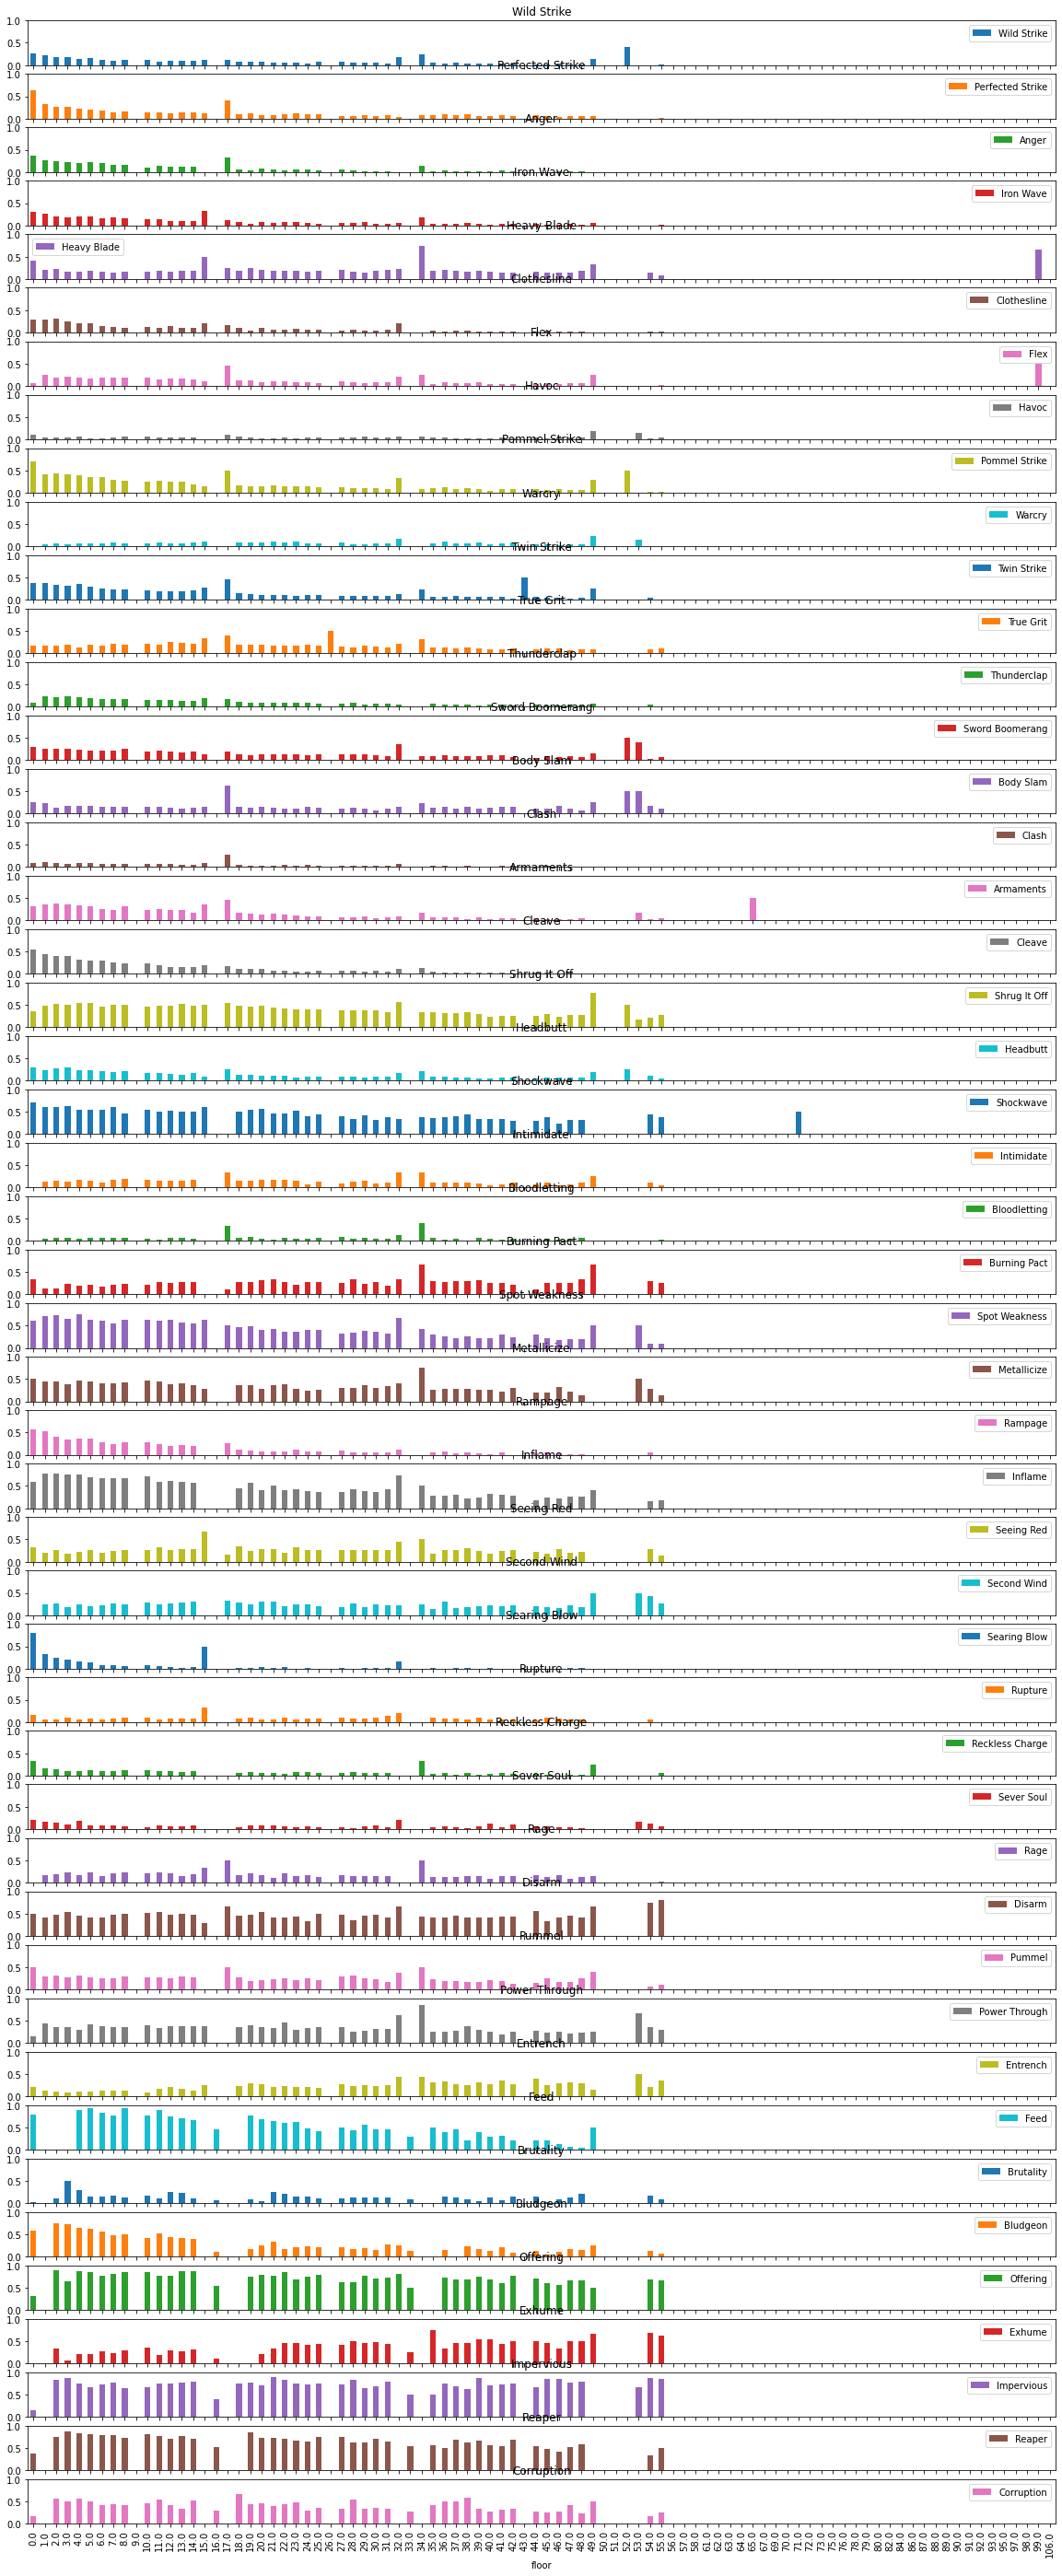

In [13]:
%%time
print(pickrate_df.loc[[
    'Wild Strike',
    'Perfected Strike',
    'Anger',
    'Iron Wave',
    'Heavy Blade',
    'Clothesline',
    'Flex',
    'Havoc',
    'Pommel Strike',
    'Warcry',
    'Twin Strike',
    'True Grit',
    'Thunderclap',
    'Sword Boomerang',
    'Body Slam',
    'Clash',
    'Armaments',
    'Cleave',
    'Shrug It Off',
    'Headbutt',
    'Shockwave',
    'Intimidate',
    'Bloodletting',
    'Burning Pact',
    'Spot Weakness',
    'Metallicize',
    'Rampage',
    'Inflame',
    'Seeing Red',
    'Second Wind',
    'Searing Blow',
    'Rupture',
    'Reckless Charge',
    'Sever Soul',
    'Rage',
    'Disarm',
    'Pummel',
    'Power Through',
    
    'Entrench',
    
    'Feed',
    'Brutality',
    'Bludgeon',
    'Offering',
    'Exhume',
    'Impervious',
    'Reaper',
    'Corruption',
]].T.plot(kind="bar", figsize=(20, 50), subplots=True, ylim=(0,1)))

In [14]:
%%time
picks_df.loc['SKIP']

CPU times: user 325 µs, sys: 14 µs, total: 339 µs
Wall time: 345 µs


floor
0.0         NaN
1.0      1469.0
2.0       625.0
3.0       754.0
4.0       959.0
          ...  
95.0        2.0
97.0        3.0
98.0        2.0
99.0       19.0
106.0       1.0
Name: SKIP, Length: 90, dtype: float64

In [15]:
picks_df.sum()

floor
0.0       1244.0
1.0      11608.0
2.0       4208.0
3.0       4693.0
4.0       5174.0
          ...   
95.0         2.0
97.0         3.0
98.0         2.0
99.0        24.0
106.0        1.0
Length: 90, dtype: float64

array([<AxesSubplot:title={'center':'None'}, xlabel='floor'>],
      dtype=object)

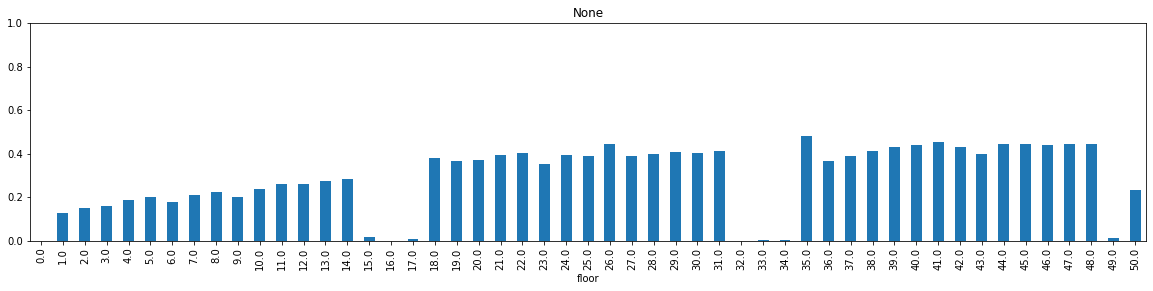

In [16]:
skip_pick_rate = (picks_df.loc['SKIP'] / picks_df.sum())[:50]
skip_pick_rate.plot(kind="bar", figsize=(20, 4), subplots=True, ylim=(0, 1))

CPU times: user 4.22 s, sys: 137 ms, total: 4.35 s
Wall time: 4.2 s


array([<AxesSubplot:title={'center':'Wild Strike'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Perfected Strike'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Anger'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Iron Wave'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Heavy Blade'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Clothesline'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Flex'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Havoc'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Pommel Strike'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Warcry'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Twin Strike'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'True Grit'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Thunderclap'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Sword Boomerang'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Body Slam'}, x

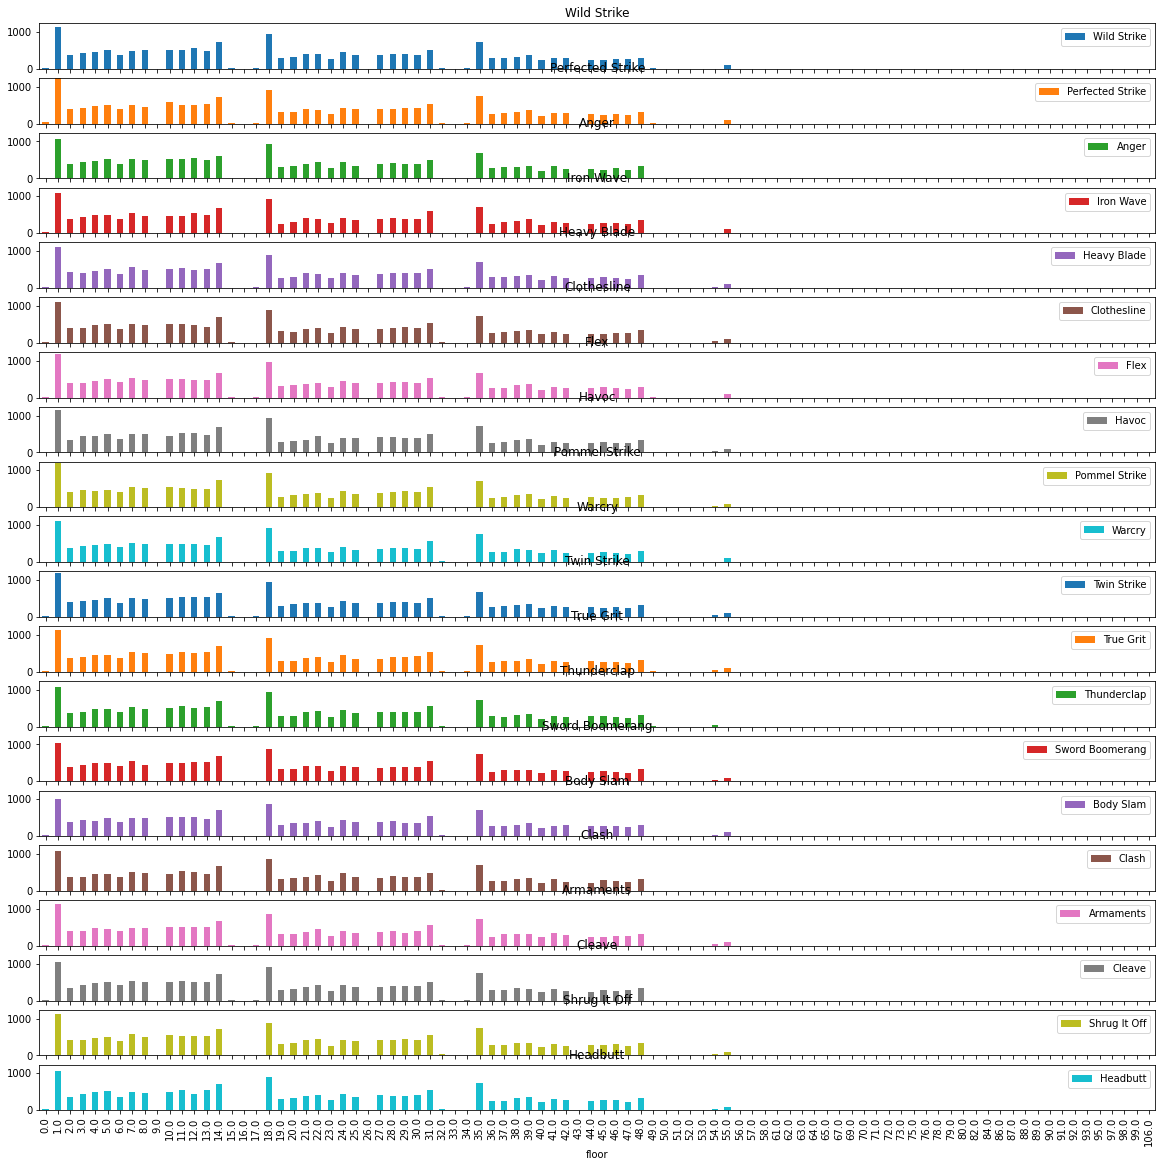

In [17]:
%%time
offered_commons = offered_df.loc[[
    'Wild Strike',
    'Perfected Strike',
    'Anger',
    'Iron Wave',
    'Heavy Blade',
    'Clothesline',
    'Flex',
    'Havoc',
    'Pommel Strike',
    'Warcry',
    'Twin Strike',
    'True Grit',
    'Thunderclap',
    'Sword Boomerang',
    'Body Slam',
    'Clash',
    'Armaments',
    'Cleave',
    'Shrug It Off',
    'Headbutt',
]]
offered_commons.T.plot(kind="bar", figsize=(20, len(offered_commons.index)), subplots=True, ylim=(0, offered_commons.max().max()))

CPU times: user 3.38 s, sys: 174 ms, total: 3.55 s
Wall time: 3.39 s


array([<AxesSubplot:title={'center':'Shockwave'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Intimidate'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Bloodletting'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Burning Pact'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Spot Weakness'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Metallicize'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Rampage'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Inflame'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Seeing Red'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Second Wind'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Searing Blow'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Rupture'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Reckless Charge'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Sever Soul'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Rage'

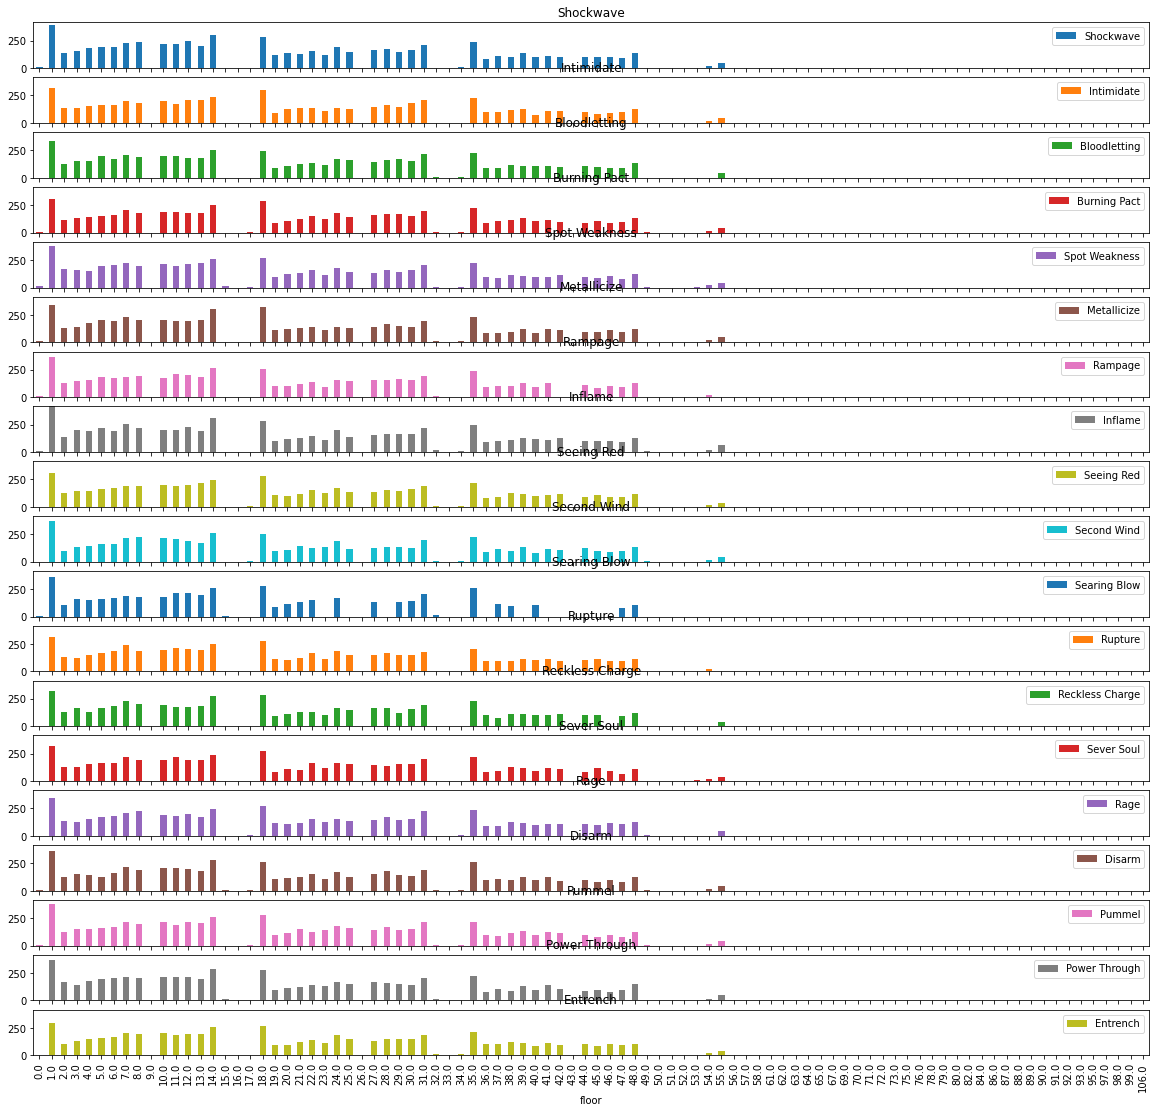

In [18]:
%%time
offered_uncommons = offered_df.loc[[
    'Shockwave',
    'Intimidate',
    'Bloodletting',
    'Burning Pact',
    'Spot Weakness',
    'Metallicize',
    'Rampage',
    'Inflame',
    'Seeing Red',
    'Second Wind',
    'Searing Blow',
    'Rupture',
    'Reckless Charge',
    'Sever Soul',
    'Rage',
    'Disarm',
    'Pummel',
    'Power Through',
    # missing items
    'Entrench',
    # missing items
]]
offered_uncommons.T.plot(kind="bar", figsize=(20, len(offered_uncommons.index)), subplots=True, ylim=(0, offered_uncommons.max().max()))

CPU times: user 2.84 s, sys: 157 ms, total: 3 s
Wall time: 2.85 s


array([<AxesSubplot:title={'center':'Demon Form'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Juggernaut'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Offering'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Feed'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Corruption'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Berserk'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Reaper'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Bludgeon'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Limit Break'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Double Tap'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Exhume'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Immolate'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Fiend Fire'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Barricade'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Brutality'}, xlabel='floor'>,
    

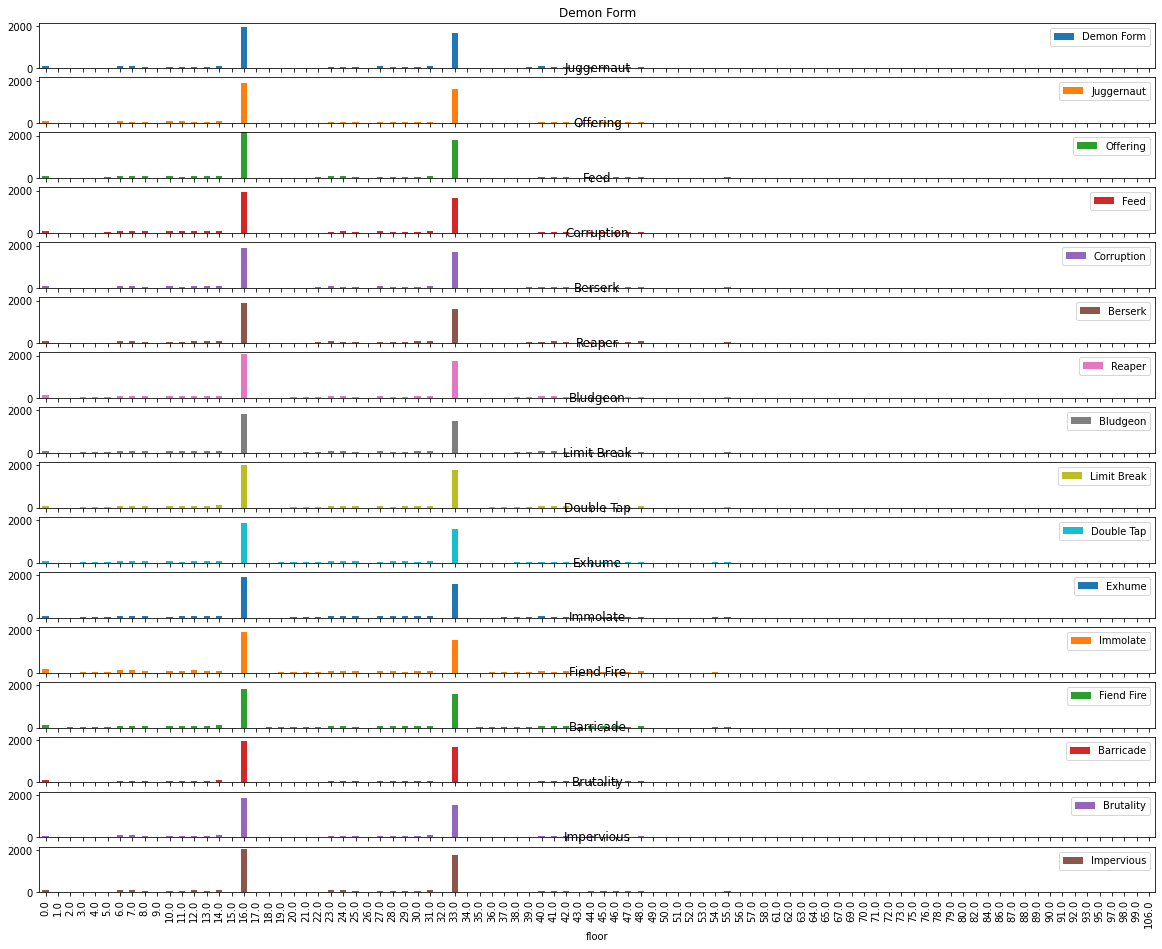

In [19]:
%%time
offered_rares = offered_df.loc[rares]

offered_rares.T.plot(kind="bar", figsize=(20, len(offered_rares.index)), subplots=True, ylim=(0, offered_rares.max().max()))

In [20]:
offers_by_floor = offered_df.sum()
offers_by_floor[:5]

floor
0.0     3674.0
1.0    34730.0
2.0    12567.0
3.0    13998.0
4.0    15450.0
5.0    16640.0
dtype: float64

array([<AxesSubplot:title={'center':'Demon Form'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Juggernaut'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Offering'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Feed'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Corruption'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Berserk'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Reaper'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Bludgeon'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Limit Break'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Double Tap'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Exhume'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Immolate'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Fiend Fire'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Barricade'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Brutality'}, xlabel='floor'>,
    

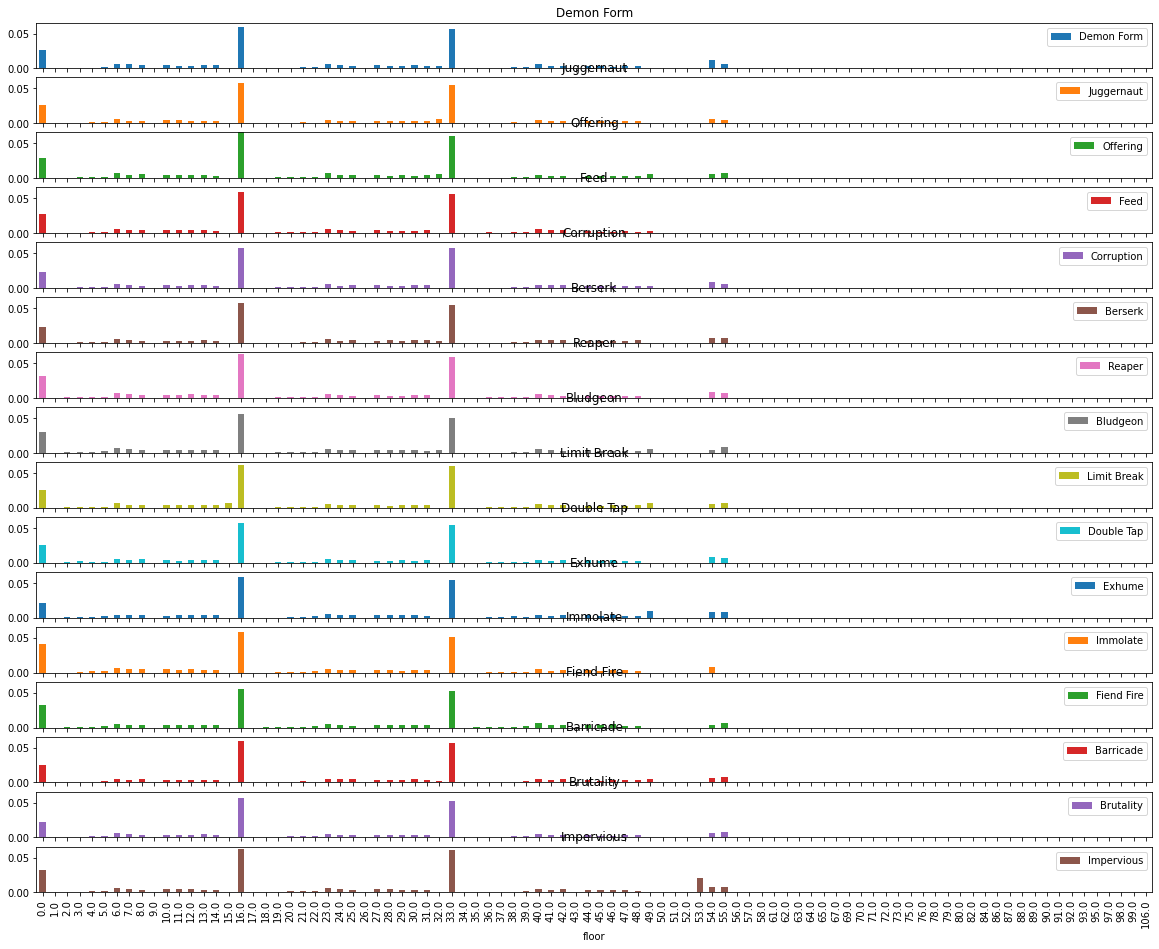

In [21]:
offer_rates = offered_df / offers_by_floor
offer_rates_rares = offer_rates.loc[rares]
offer_rates_rares.T.plot(kind="bar", figsize=(20, len(offer_rates_rares.index)), subplots=True, ylim=(0, offer_rates_rares.max().max()))

In [22]:
a = offered_df.loc['Corruption'][16]
b = offers_by_floor.loc[16]
print(a)
print(b)
print(a / b)
print(offered_df.loc[rares][16].sum())

1902.0
32823.0
0.057947171190933185
30955.0
